# 频繁模式与关联规则挖掘

张睿堃 3120230897

代码仓库地址：
https://github.com/wangzrk/Data-Mining

## 1.数据集预处理
选择Trending YouTube Video Statistics数据集进行频繁模式和关联规则挖掘。这是YouTube热门视频统计信息的数据集，包括了YouTube上热门视频的类别、频道、标题、观众喜爱数等信息。数据集中将不同国家的数据分开进行统计

In [1]:
# 导入数据处理和绘图的包
import pandas as pd
import numpy as np
import json as js
import Orange as og
import orangecontrib.associate.fpgrowth as oaf
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### 设定使用的数据
取消任意一行的注释即使用该行所示数据
这里仅选用美国的数据进行挖掘，包括40949条数据和16个属性，没有缺失值。

In [2]:
# 设定使用的数据
# csv_path, json_path = 'CAvideos.csv', 'CA_category_id.json'
# csv_path, json_path = 'DEvideos.csv', 'DE_category_id.json'
# csv_path, json_path = 'FRvideos.csv', 'FR_category_id.json'
# csv_path, json_path = 'GBvideos.csv', 'GB_category_id.json'
# csv_path, json_path = 'INvideos.csv', 'IN_category_id.json'
# csv_path, json_path = 'JPvideos.csv', 'JP_category_id.json'
# csv_path, json_path = 'KRvideos.csv', 'KR_category_id.json'
# csv_path, json_path = 'MXvideos.csv', 'MX_category_id.json'
# csv_path, json_path = 'RUvideos.csv', 'RU_category_id.json'
csv_path, json_path = 'USvideos.csv', 'US_category_id.json'

###  视频类别的替换
数据集中category_id这一属性用id代表类别，id与类别的对应关系存储在US_category_id.json中，首先用实际类别替换id

In [3]:
data = pd.read_csv(csv_path, sep = ',')
with open(json_path) as f:   # 读取json文件
    json_date = js.load(f)
    f.close()
id2cat = {}
for i in range(len(json_date['items'])):   # id与类别对应
    id2cat[json_date['items'][i]['id']] = json_date['items'][i]['snippet']['title']
for i in range(len(data)):    # 替换
    id = data.loc[i, 'category_id']
    data.loc[i, 'category_id'] = id2cat[str(id)]
print(data['category_id'])

0          People & Blogs
1           Entertainment
2                  Comedy
3           Entertainment
4           Entertainment
               ...       
40944      Pets & Animals
40945      People & Blogs
40946       Entertainment
40947    Film & Animation
40948              Gaming
Name: category_id, Length: 40949, dtype: object


### 属性选择与变换
只选择一部分有意义的属性进行挖掘，这里选择channel_title，category_id，tags，views，likes，dislikes，comment_count属性。其中有些属性是数值属性，不好进行关联规则的挖掘，因此将这些属性转化为标称属性。

对于views，首先计算views的四分之一分位数和四分之三分位数。大于四分之三分位数的数据记为"high view"，小于四分之一分位数的数据记为"low view"，其余的记为"medium view"。

In [4]:
arr = data['views']
one = arr.quantile(0.25)
three = arr.quantile(0.75)
view_level = []
for i in data['views']:
    if int(i) >= three:
        view_level.append('high view')
    elif int(i) <= one:
        view_level.append('low view')
    else:
        view_level.append('medium view')
print(view_level[:10])

['medium view', 'high view', 'high view', 'medium view', 'high view', 'low view', 'high view', 'medium view', 'medium view', 'medium view']


In [5]:
# 对于likes和dislikes，若likes的人数 >= dislikes的人数，则标记这个视频为"like"，否则为"dislike"
like = []
for i in range(len(data)):
    if data.loc[i, 'likes'] >= data.loc[i, 'dislikes']:
        like.append('like')
    else:
        like.append('dislike')
print(like[0:10])

['like', 'like', 'like', 'like', 'like', 'like', 'like', 'like', 'like', 'like']


对于comment_count，计算 $comment\_count \over views$ 的四分之一分位数和四分之三分位数。如果一条数据的 $comment\_count \over views$ 小于四分之一分位数，则记为`"low comment"`，若大于四分之三分位数，则记为`"high comment"`，其余的记为`"medium comment"`

In [6]:
arr = data['comment_count']
one = arr.quantile(0.25)
three = arr.quantile(0.75)
comment_level = []
for i in data['comment_count']:
    if i >= three:
        comment_level.append('high comment')
    elif i <= one:
        comment_level.append('low comment')
    else:
        comment_level.append('medium comment')
print(comment_level[0:10])

['high comment', 'high comment', 'high comment', 'medium comment', 'high comment', 'medium comment', 'medium comment', 'medium comment', 'low comment', 'medium comment']


In [7]:
# 将views，likes，dislikes，comment_count这四个属性替换为刚刚计算出的结果。
data = data.drop(['views', 'likes', 'dislikes', 'comment_count'], axis = 1)
data.insert(0, 'views', view_level)
data.insert(0, 'like', like)
data.insert(0, 'comment_count', comment_level)
# 删除不要的
data = data.drop(['video_id', 'trending_date', 'publish_time', 'video_error_or_removed', 'description', 'thumbnail_link', 'title', 'comments_disabled', 'ratings_disabled'], axis = 1)
print(data.head())

    comment_count  like        views          channel_title     category_id  \
0    high comment  like  medium view           CaseyNeistat  People & Blogs   
1    high comment  like    high view        LastWeekTonight   Entertainment   
2    high comment  like    high view           Rudy Mancuso          Comedy   
3  medium comment  like  medium view  Good Mythical Morning   Entertainment   
4    high comment  like    high view               nigahiga   Entertainment   

                                                tags  
0                                    SHANtell martin  
1  last week tonight trump presidency|"last week ...  
2  racist superman|"rudy"|"mancuso"|"king"|"bach"...  
3  rhett and link|"gmm"|"good mythical morning"|"...  
4  ryan|"higa"|"higatv"|"nigahiga"|"i dare you"|"...  


### 输入格式转换
由于使用orangecontrib.associate.fpgrowth包进行频繁模式与关联规则挖掘时，输入的数据必须是整数类型的列表，因此需要将所有的字符串转化为整数。由于tags属性是多个tag的组合，为了能区分出不同的tag，还需将tags分割成各个tag。

In [8]:
# 算法输入格式转换（转换后输出前5条为例）
id2str = {}   # 整数编码 —> 字符串
str2id = {}   # 字符串 -> 整数编码
id = 0
transaction = []
for i in range(len(data)):
    one = []
    for j in data.columns:
        # 拆分tags
        if j == 'tags':
            str_arr = data.loc[i, j].split('|')
            for s in str_arr:
                if s in str2id:
                    one.append(str2id[s])
                else:
                    id2str[id] = s
                    str2id[s] = id
                    one.append(id)
                    id += 1
        else:
            if data.loc[i, j] in str2id:
                one.append(str2id[data.loc[i, j]])
            else:
                id2str[id] = data.loc[i, j]
                str2id[data.loc[i, j]] = id
                one.append(id)
                id += 1
    transaction.append(one)
print(transaction[:10])

[[0, 1, 2, 3, 4, 5], [0, 1, 6, 7, 8, 9, 10, 11, 12], [0, 1, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37], [38, 1, 2, 39, 8, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66], [0, 1, 6, 67, 8, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 64, 65, 78, 79], [38, 1, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89], [38, 1, 6, 90, 8, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 64, 107, 65, 108, 109, 110, 57, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129], [38, 1, 2, 130, 82, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143], [144, 1, 2, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174], [38, 1, 2, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196]

##  2.频繁模式挖掘
使用orangecontrib.associate.fpgrowth包进行频繁模式挖掘。首先使用默认的0.2作为频繁模式的相对支持度支持度阈值。

In [9]:
items = list(oaf.frequent_itemsets(transaction))
for i in items:
    print(i)

(frozenset({0}), 10239)
(frozenset({1}), 40373)
(frozenset({0, 1}), 10141)
(frozenset({2}), 20472)
(frozenset({1, 2}), 20263)
(frozenset({6}), 10238)
(frozenset({1, 6}), 10205)
(frozenset({8}), 9964)
(frozenset({8, 1}), 9808)
(frozenset({38}), 20460)
(frozenset({1, 38}), 20256)
(frozenset({2, 38}), 15081)
(frozenset({1, 2, 38}), 14974)
(frozenset({80}), 10239)
(frozenset({80, 1}), 9905)
(frozenset({144}), 10250)
(frozenset({144, 1}), 9976)


frozenset是项集，后面的数字是这个项集的绝对支持度。为了更好地显示频繁项集，下面将数字重新转化为原始的字符串，同时计算相对支持度。

In [10]:
for i in items:
    freq_set = []
    abs_sup = i[1]
    for j in i[0]:
        freq_set.append(id2str[j])
    print(freq_set, abs_sup, round(float(abs_sup) / len(data), 2))

['high comment'] 10239 0.25
['like'] 40373 0.99
['high comment', 'like'] 10141 0.25
['medium view'] 20472 0.5
['like', 'medium view'] 20263 0.49
['high view'] 10238 0.25
['like', 'high view'] 10205 0.25
['Entertainment'] 9964 0.24
['Entertainment', 'like'] 9808 0.24
['medium comment'] 20460 0.5
['like', 'medium comment'] 20256 0.49
['medium view', 'medium comment'] 15081 0.37
['like', 'medium view', 'medium comment'] 14974 0.37
['low view'] 10239 0.25
['low view', 'like'] 9905 0.24
['low comment'] 10250 0.25
['low comment', 'like'] 9976 0.24


In [11]:
# 改用0.3作为相对支持度阈值，再次计算频繁项集
items = list(oaf.frequent_itemsets(transaction, 0.3))
for i in items:
    freq_set = []
    abs_sup = i[1]
    for j in i[0]:
        freq_set.append(id2str[j])
    print(freq_set, abs_sup, round(float(abs_sup) / len(data), 2))

['like'] 40373 0.99
['medium view'] 20472 0.5
['like', 'medium view'] 20263 0.49
['medium comment'] 20460 0.5
['like', 'medium comment'] 20256 0.49
['medium view', 'medium comment'] 15081 0.37
['like', 'medium view', 'medium comment'] 14974 0.37


## 3.关联规则挖掘
在计算出频繁项集的基础上，计算关联规则，置信度阈值选择为0.2，结果转化为原始字符串输出.

In [12]:
# 关联规则
items = list(oaf.frequent_itemsets(transaction, 0.2))
rules = list(oaf.association_rules(dict(items), 0.2))
for i in rules:
    antecedent = []
    consequent = []
    for j in i[0]:
        antecedent.append(id2str[j])
    for j in i[1]:
        consequent.append(id2str[j])
    print(antecedent, "->", consequent, i[2], round(i[3],2))
print(len(rules))

['medium view', 'medium comment'] -> ['like'] 14974 0.99
['like', 'medium comment'] -> ['medium view'] 14974 0.74
['medium comment'] -> ['like', 'medium view'] 14974 0.73
['like', 'medium view'] -> ['medium comment'] 14974 0.74
['medium view'] -> ['like', 'medium comment'] 14974 0.73
['like'] -> ['medium view', 'medium comment'] 14974 0.37
['like'] -> ['high comment'] 10141 0.25
['high comment'] -> ['like'] 10141 0.99
['medium view'] -> ['like'] 20263 0.99
['like'] -> ['medium view'] 20263 0.5
['high view'] -> ['like'] 10205 1.0
['like'] -> ['high view'] 10205 0.25
['like'] -> ['Entertainment'] 9808 0.24
['Entertainment'] -> ['like'] 9808 0.98
['medium comment'] -> ['like'] 20256 0.99
['like'] -> ['medium comment'] 20256 0.5
['medium comment'] -> ['medium view'] 15081 0.74
['medium view'] -> ['medium comment'] 15081 0.74
['like'] -> ['low view'] 9905 0.25
['low view'] -> ['like'] 9905 0.97
['like'] -> ['low comment'] 9976 0.25
['low comment'] -> ['like'] 9976 0.97
22


## 4.关联规则的评价
使用**Lift**和**Kulc**两种评价指标评价关联规则。

### Lift

In [13]:
measure = list(oaf.rules_stats(oaf.association_rules(dict(items), 0.2), dict(oaf.frequent_itemsets(transaction, 0.2)), len(data)))
for i in measure:
    antecedent = []
    consequent = []
    for j in i[0]:
        antecedent.append(id2str[j])
    for j in i[1]:
        consequent.append(id2str[j])
    print(antecedent, "->", consequent, round(i[6], 2))

['medium view', 'medium comment'] -> ['like'] 1.01
['like', 'medium comment'] -> ['medium view'] 1.48
['medium comment'] -> ['like', 'medium view'] 1.48
['like', 'medium view'] -> ['medium comment'] 1.48
['medium view'] -> ['like', 'medium comment'] 1.48
['like'] -> ['medium view', 'medium comment'] 1.01
['like'] -> ['high comment'] 1.0
['high comment'] -> ['like'] 1.0
['medium view'] -> ['like'] 1.0
['like'] -> ['medium view'] 1.0
['high view'] -> ['like'] 1.01
['like'] -> ['high view'] 1.01
['like'] -> ['Entertainment'] 1.0
['Entertainment'] -> ['like'] 1.0
['medium comment'] -> ['like'] 1.0
['like'] -> ['medium comment'] 1.0
['medium comment'] -> ['medium view'] 1.47
['medium view'] -> ['medium comment'] 1.47
['like'] -> ['low view'] 0.98
['low view'] -> ['like'] 0.98
['like'] -> ['low comment'] 0.99
['low comment'] -> ['like'] 0.99


### Kulc
Kulc的计算公式为 : $Kulc(A,B) = {1\over 2} \times ({s(A\cup B) \over s(A)} + {s(A\cup B) \over s(B)})$ ,即A->B的规则与B->A的规则的置信度的平均值，由于所有找出的关联规则都包含对应的反向的规则，因此直接在现有的关联规则中计算Kulc

In [14]:
# 计算Kulc
kulc = []
visit = [False for i in range(len(rules))]
for i in range(len(rules)):
    if visit[i] == True:
        continue
    visit[i] = True
    for j in range(len(rules)):
        if visit[j] == True:
            continue
        if rules[j][0] == rules[i][1] and rules[j][1] == rules[i][0]:
            one = []
            antecedent = []
            consequent = []
            for k in rules[i][0]:
                antecedent.append(id2str[k])
            for k in rules[i][1]:
                consequent.append(id2str[k])
            one.append(rules[i][0])
            one.append(rules[i][1])
            one.append((rules[i][3] + rules[j][3])/2)
            kulc.append(one)
            print('Kulc(', antecedent, consequent, ') = ', round((rules[i][3] + rules[j][3])/2, 2))
            visit[j] = True

Kulc( ['medium view', 'medium comment'] ['like'] ) =  0.68
Kulc( ['like', 'medium comment'] ['medium view'] ) =  0.74
Kulc( ['medium comment'] ['like', 'medium view'] ) =  0.74
Kulc( ['like'] ['high comment'] ) =  0.62
Kulc( ['medium view'] ['like'] ) =  0.75
Kulc( ['high view'] ['like'] ) =  0.62
Kulc( ['like'] ['Entertainment'] ) =  0.61
Kulc( ['medium comment'] ['like'] ) =  0.75
Kulc( ['medium comment'] ['medium view'] ) =  0.74
Kulc( ['like'] ['low view'] ) =  0.61
Kulc( ['like'] ['low comment'] ) =  0.61


## 5.挖掘结果的分析
lift可以用于衡量关联规则中两个项目的相关度，$lift(A,B)>1$说明A与B正相关，$lift(A,B)=1$说明A与B相互独立，$lift(A,B)<1$说明A与B负相关。在所有的22条关联规则中，lift值大于1的只有6条（有两条的lift = 1.01，这里近似认为其等于1），分别是：
```text
['like', 'medium comment'] -> ['medium view'] 1.48
['medium comment'] -> ['like', 'medium view'] 1.48
['like', 'medium view'] -> ['medium comment'] 1.48
['medium view'] -> ['like', 'medium comment'] 1.48
['medium comment'] -> ['medium view'] 1.47
['medium view'] -> ['medium comment'] 1.47
```
这6条规则的Kulc值如下：
```text
Kulc( ['like', 'medium comment'] ['medium view'] ) = 0.7353379092284642
Kulc( ['medium comment'] ['like', 'medium view'] ) = 0.7354247196772028
Kulc( ['medium comment'] ['medium view'] ) = 0.7368807434859888
```
在所有计算出的关联规则的Kulc值中，这三个Kulc值属于比较大的。因此可以认为这6条关联规则是可以接受的。可以得到结论：
```text
1.观众喜爱的，且评论数量中等的，会有中等的观看量
2.观众喜爱的，且观看量中等的，会有中等的评论量
3.中等的观看量的视频会有中等评论量 以上三条结论，反过来也成立。
```
在关联规则中，有一条的置信度很高：
```text
['low view'] -> ['like'] 9905 0.97
```
说明观看量少的，观众会喜爱，这与我们的发现不符。这条规则的Lift值为0.98，说明这两项实际上是负相关的Kulc值为0.606，是所有Kulc值中最小的。说明这条关联规则是具有误导性的，推测原因可能是因为"like"项或"low view"项出现次数太多。

In [15]:
# 查看“like” 数量和 “low view” 数量
like_cnt = 0
low_view_cnt = 0
for i in data['like']:
    if i == 'like':
        like_cnt += 1
for i in data['views']:
    if i == 'low view':
        low_view_cnt += 1
print(like_cnt, low_view_cnt)

40373 10239


在40949条数据中，有40373项"like"，占到了98.6%。因此导致出现了有误导性的关于"like"的关联规则

## 6.可视化展示
绘制关联规则的置信度、Lift和Kulc相关性热图
横纵坐标是关联规则中包含的项（共11项），热图中每个点的数据是两项的置信度、Lift值或Kulc值

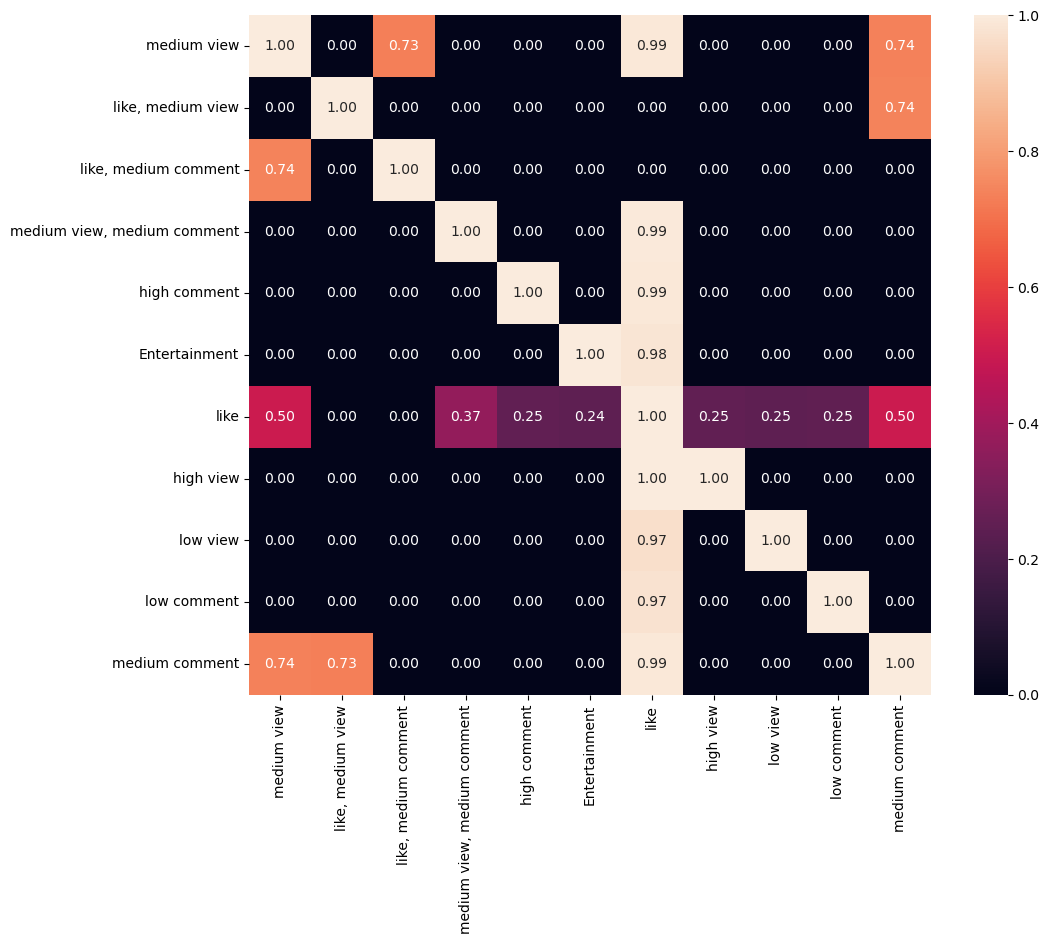

In [16]:
# 利用置信度绘制热图
conf_matrix = []
rules_column = set()

for i in range(len(measure)):
    rules_column.add(measure[i][0])
# 计算置信度矩阵
for i in rules_column:
    one = []
    for j in rules_column:
        if i == j:
            one.append(1)
        else:
            flag = False
            for k in range(len(rules)):
                if rules[k][0] == i and rules[k][1] == j:
                    one.append(rules[k][3])
                    flag = True
            if flag == False:
                one.append(0)
    conf_matrix.append(one)
# 改columns名字
rules_column_list = []
for i in rules_column:
    one = ""
    for j in range(len(i)):
        one += id2str[j]
        if j < len(i) - 1:
            one += ", "
    rules_column_list.append(one)
# 绘制热图的数据
rules_column = list(rules_column)
rules_column_list = []
for i in rules_column:
    one = ""
    for j in range(len(i)):
        one += id2str[list(i)[j]]
        if j < len(i) - 1:
            one += ", "
    rules_column_list.append(one)

conf_pd = pd.DataFrame(conf_matrix, columns = rules_column_list, index = rules_column_list)
plt.figure(figsize=(11, 9),dpi=100)
sns.heatmap(data = conf_pd, annot = True, fmt = ".2f")
plt.show()

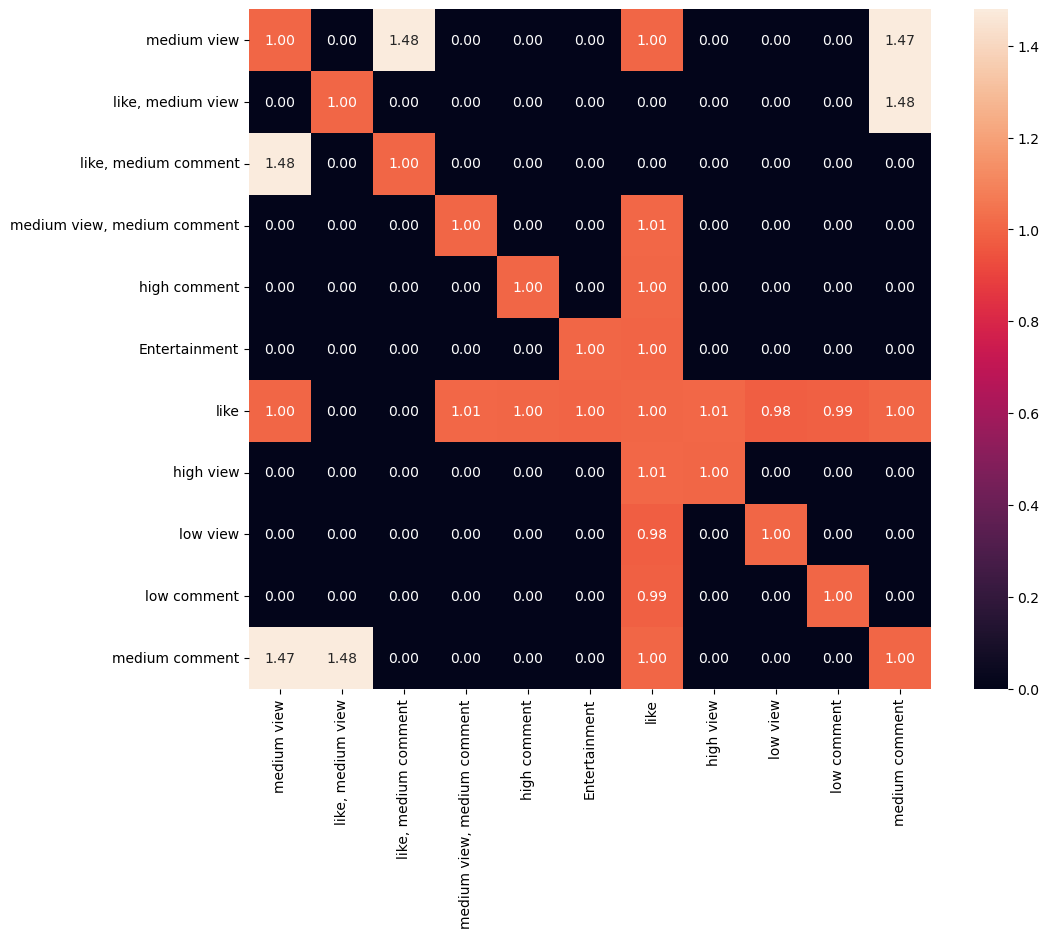

In [17]:
# 使用Lift值绘制热图
# 计算lift矩阵
lift_matrix = []
for i in rules_column:
    one = []
    for j in rules_column:
        if i == j:
            one.append(1)
        else:
            flag = False
            for k in range(len(measure)):
                if measure[k][0] == i and measure[k][1] == j:
                    one.append(measure[k][6])
                    flag = True
            if flag == False:
                one.append(0)
    lift_matrix.append(one)

lift_pd = pd.DataFrame(lift_matrix, columns = rules_column_list, index = rules_column_list)
plt.figure(figsize=(11, 9),dpi=100)
sns.heatmap(data = lift_pd, annot = True, fmt = ".2f")
plt.show()

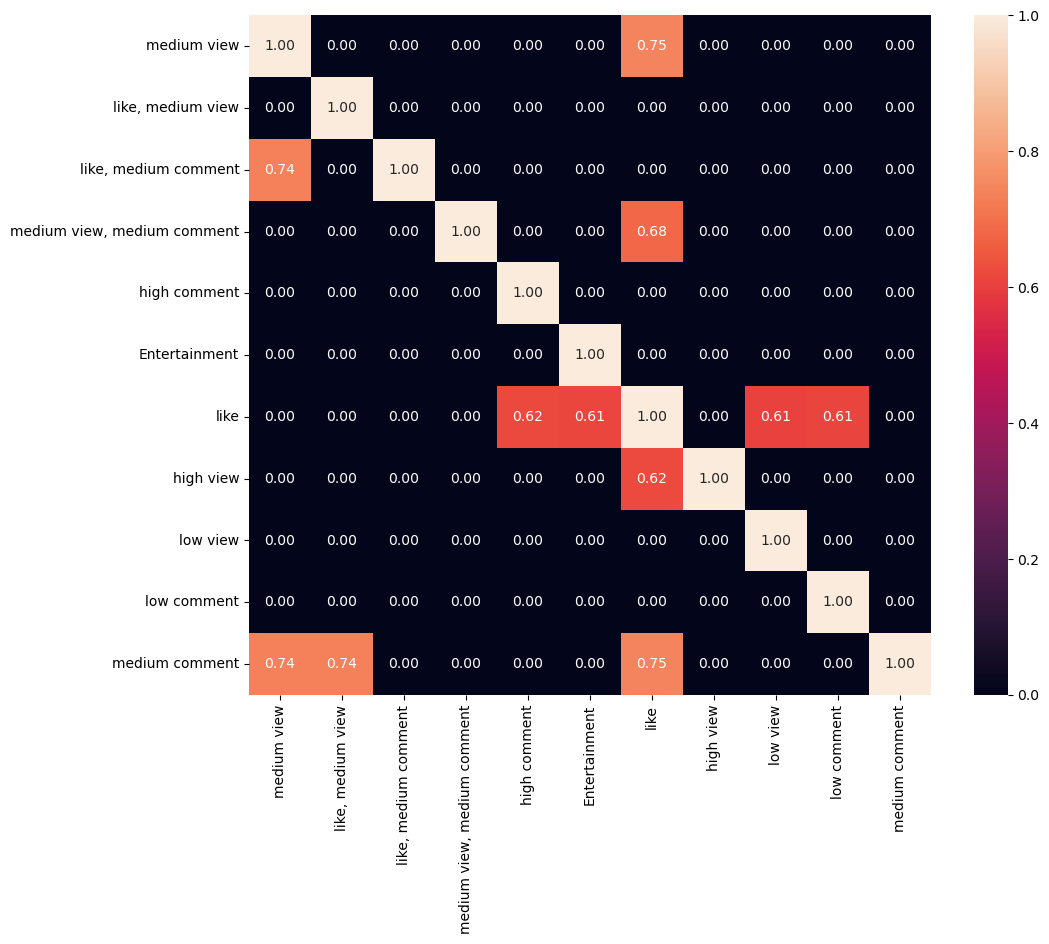

In [18]:
# 使用Kulc值绘制热图
kulc_matrix = []
# 计算kulc矩阵
for i in rules_column:
    one = []
    for j in rules_column:
        if i == j:
            one.append(1)
        else:
            flag = False
            for k in range(len(kulc)):
                if kulc[k][0] == i and kulc[k][1] == j:
                    one.append(kulc[k][2])
                    flag = True
            if flag == False:
                one.append(0)
    kulc_matrix.append(one)
    
kulc_pd = pd.DataFrame(kulc_matrix, columns = rules_column_list, index = rules_column_list)
plt.figure(figsize=(11, 9),dpi=100)
sns.heatmap(data = kulc_pd, annot = True, fmt = ".2f")
plt.show()